In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

c:\users\akala\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\akala\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\akala\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#Data
disease_types=['COVID', 'non-COVID']
data_dir = 'dataset'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [4]:
#Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1227).png,0,COVID
1,COVID/Covid (430).png,0,COVID
2,non-COVID/Non-Covid (322).png,1,non-COVID
3,non-COVID/Non-Covid (379).png,1,non-COVID
4,COVID/Covid (609).png,0,COVID


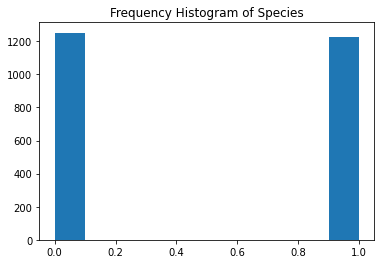

<Figure size 864x864 with 0 Axes>

In [5]:
#Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

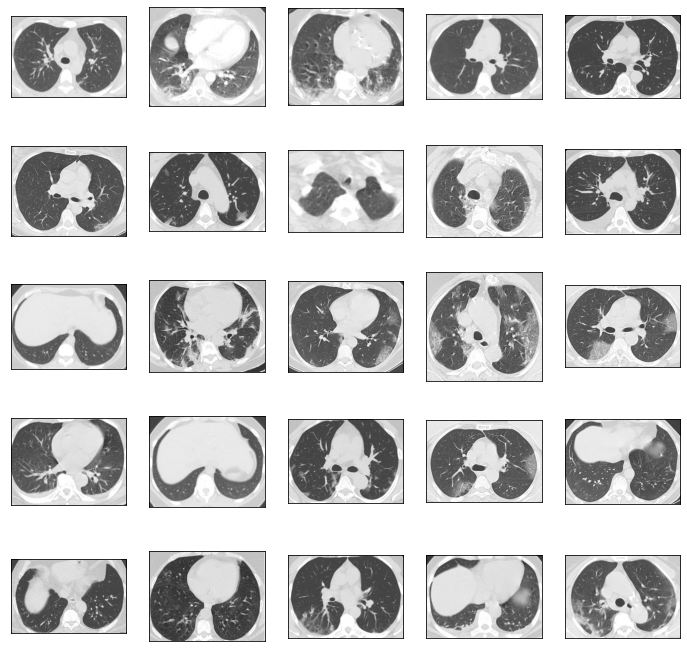

In [6]:
#Display images of COVID
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

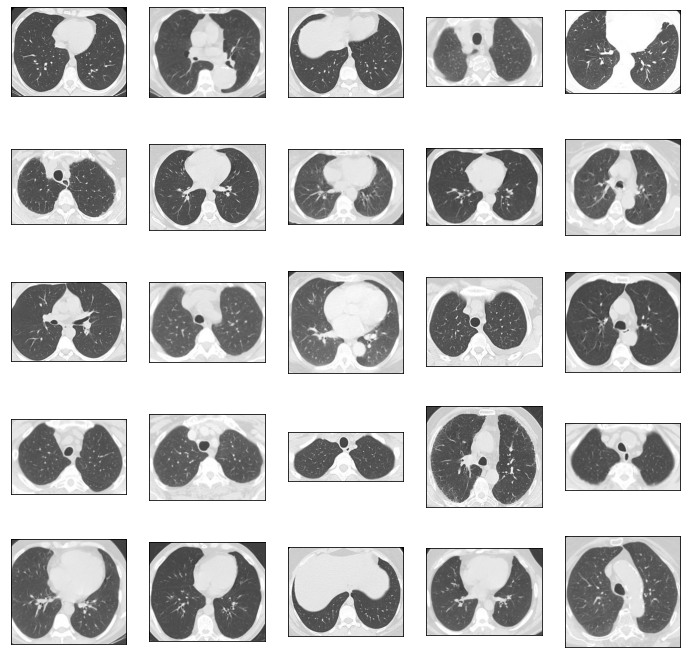

In [7]:
#Display images of non-COVID
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_defects('non-COVID', 5, 5)

In [8]:
#Image Read and Resize Function
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) #Display images of non-COVID

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
#Training Images
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:15, 163.57it/s]


Train Shape: (2481, 64, 64, 3)


In [10]:
#Converting Labels to Categorical
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [11]:
#Train Test Splitting
BATCH_SIZE = 64


X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

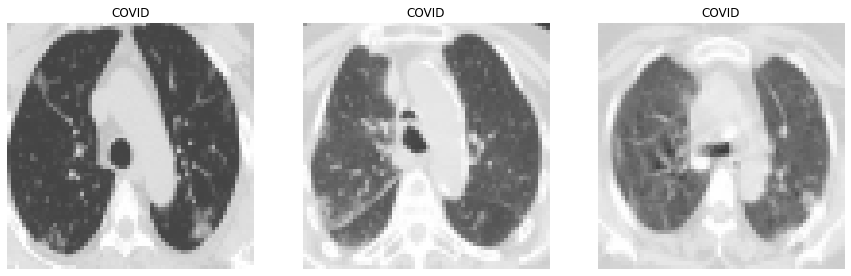

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [13]:
EPOCHS = 50
SIZE = 64
N_ch = 3

In [14]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

#image processing methods
def imgPro(img):    
    blured_img = cv2.medianBlur(img,(5,5)) # median filter with 5 x 5 kernal size
    img_adapteq = exposure.equalize_adapthist(blured_img, clip_limit=0.03) # histogram equalization
    return img_adapteq

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True
                        preprocessing_function=imgPro) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

Epoch 36/50

Epoch 00036: val_loss improved from 0.27758 to 0.27734, saving model to model.h5
31/31 - 138s - loss: 0.3121 - accuracy: 0.8624 - val_loss: 0.2773 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 37/50

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00037: val_loss did not improve from 0.27734
31/31 - 126s - loss: 0.3011 - accuracy: 0.8725 - val_loss: 0.5069 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 38/50

Epoch 00038: val_loss did not improve from 0.27734
31/31 - 121s - loss: 0.2955 - accuracy: 0.8695 - val_loss: 0.7234 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 39/50

Epoch 00039: val_loss did not improve from 0.27734
31/31 - 121s - loss: 0.3126 - accuracy: 0.8649 - val_loss: 1.0717 - val_accuracy: 0.6137 - lr: 0.0010
Epoch 40/50

Epoch 00040: val_loss did not improve from 0.27734
31/31 - 138s - loss: 0.3045 - accuracy: 0.8674 - val_loss: 1.1782 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 41/50

Epoch 00041: val_loss did not improve from 0.27734
31/31 - 139

In [16]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 5s 328ms/step - loss: 0.2619 - accuracy: 0.8793
Final Loss: 0.26187294721603394, Final Accuracy: 0.8792756795883179


Text(0.5, 145.31999999999996, 'Predicted')

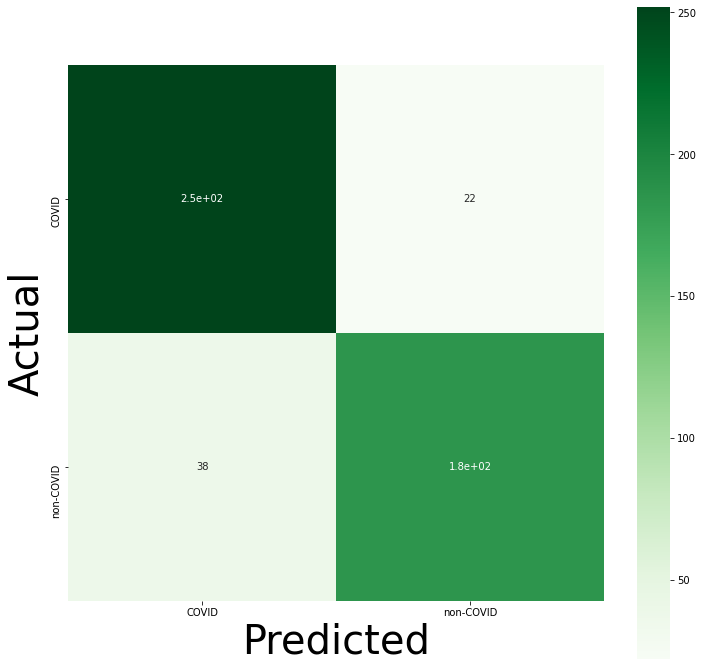

In [17]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

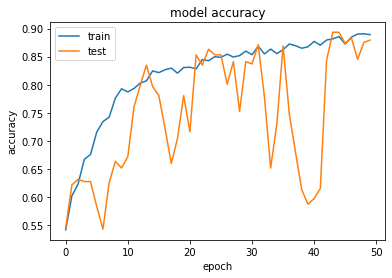

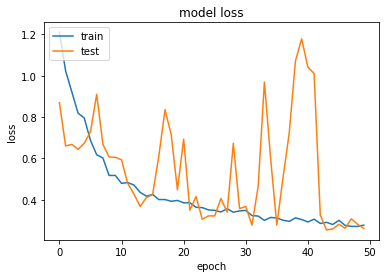

In [18]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[9.9955720e-01 4.4277756e-04]


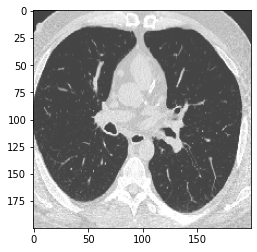

Prediction: Covid-19


In [29]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('dataset/COVID/Covid (109).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('dataset/COVID/Covid (109).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [ ]:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
root (Dense)                 (None, 2)                 514       
=================================================================
Total params: 7,305,622
Trainable params: 7,219,414
Non-trainable params: 86,208